In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Goal 
Since an image is a discrete mapping of pixels, while the real world is "continuous", we want to fit the pixels by a continuous functions so that we can extract information. 

# Sliding Window Algorithm
- Define a "pixel window" centered at pixel $(x, y)$ so that an 1D patch can be $(0, y)\sim (2x,y)$
- Fit a n-degree polynomial to the intensities (commonly $n \leq 2$)
- Assign the poly's derivatives at $x=0$ to pixel at windows's center
- Slide window one pixel over until window reaches border

# Taylor-series Approximation of Images
Consider a 1D patch from $(0,y)$ to $(2x,y)$  
Consider the Taylor expansion of $I$ centered at $0$
$$I(\vec x) = \sum_{i=0}^\infty \frac{d^iI}{d\vec x^i}\vec x^i I(0) \approx \sum_{i=0}^N \frac{d^iI}{d\vec x^i}\vec x^i I(0) + R_{N+1}(x)$$
Thus, we can write it as 
$$I(x) = [1, x, x^2/2, x^3/6,...,x^n/n!][I(0), d_xI(0), d^2_{x^2}I(0), ..., d^n_{x^n}I(0)]^T$$

Note that we have $2x+1$ pixels in the patch, ranges from $-x$ to $x$, let their intensities be $I_x$. So that we have
$$
\begin{bmatrix}
I_{-x}\\
I_{-x+1}\\
...\\
I_{x-1}\\
I_{x}
\end{bmatrix}=
\begin{bmatrix}
1 &-x &...&(-x)^n/n!\\
1 &(-x+1) &...&(-x+1)^n/n!\\
... &... &...&...\\
1 &(x-1) &...&(x-1)^n/n!\\
1 &x &...&x^n/n!\\
\end{bmatrix}  
\begin{bmatrix}
I(0)\\d_xI(0)\\...\\d^{n-1}_{x^{n-1}}I(0)\\d^n_{x^n}I(0)\end{bmatrix}$$
$$I_{(2x+1)\times 1}=X_{(2x+1)\times n}d_{n\times 1}$$
where $I, X$ are known and we want to solve $d$

Since this is not always have a solution. We want to minimize the "fit error" $\|I-Xd\|^2 = \sqrt{\sum^n I_i^2}$

When $n = 0$, obviously $d$ is minimized at mean, i.e. $\sum^{2x+1} I_i / (2x+1)$

# Weighted least square estimation
If we want to extract more information, or in favor of, the neighboring points, we can have $I' = \Omega I$ where $\Omega$ is the weight function. 

In 1-D case, let $\Omega = diag(\omega_1, ..., \omega_{2x+1})$, we want to solve $\Omega I = \Omega X d$ which is to minimize $\|\Omega(I-Xd)\|^2$

# Random Sample Consensus (RANSAC)
Suppose we have some outliers, then the line fitting with least square is not a good solution. 

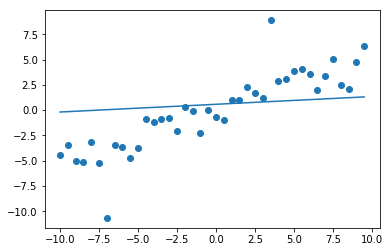

In [41]:
x = np.arange(-10, 10, 0.5)
y = x * 0.5 + np.random.normal(0, 1, x.shape)
y += (np.random.randn(y.shape[0]) < -1.5) * 8
y -= (np.random.randn(y.shape[0]) < -1.5) * 8
fit = np.polyfit(x, y, 1)
f = fit[0] + fit[1] * x
plt.scatter(x, y)
plt.plot(x, f);

## Algorithm 
Given:  
$n=$ degree of freedom (unkonwn polynomial coefficients)  
$p=$ fraction of inliers  
$t = $ fit threshold  
$P_s = $ success probability  
$K=$ max number of iterations

```python
RANSAC:
    for _ in K:
        randomly choose n + 1 pixels
        fit a n-degree polynomial
        count pixels whose vertical distance from poly is < t
        if there are >= (2w+1) * p pixels, mark them as inliers:
            do n-degree poly fitting on inliers 
            return the fitting
    # if there is insufficient inliers
    return None
```

Consider the value for $K$:   
Suppose inliers are independent distributed, hence 
$$P(\text{choose n+1 inliers}) = p^{n+1}$$
$$P(\text{at least 1 outliers}) = 1 - p^{n+1}$$
$$P(\text{at least 1 outliers in all K trials}) = (1-p^{n+1})^K$$
$$P_s = 1 - (1-p^{n+1})^K\Rightarrow K = \frac{\log(1-P_s)}{\log(1-p^{n+1})}$$

# 2D Image Patch
Given an image patch $I(1:W, 1:H), I\in[0,1]$ is the intensity mapping

## 2D Taylor Series Expansion
Let $I(0,0)$ be the center
\begin{align*}
I(x,y) &= I(0,0) + x\partial_xI(0,0) + y\partial_yI(0,0) \\
& + \frac{1}{2}(x^2\frac{\partial^2I}{\partial x^2}(0,0) + y^2\frac{\partial^2I}{\partial y^2}(0,0) + xy\frac{\partial^2I}{\partial x\partial y}(0,0)) + ...
\end{align*}

## Directional Derivative
Using 1st order Taylor series approximation.   
Let $\theta$ be the direction, $v=(\cos \theta, \sin\theta)$ be the unit vector in direction $\theta$.  
Consider the points $(t\cos\theta, t\sin\theta)$, i.e. $t$ units away from $(0,0)$ in the direction of $\theta$
$$I(t\cos\theta, t\sin\theta) = I(0,0) + I(0,0) + t\cos\theta\partial_xI(0,0) + t\sin\theta\partial_yI(0,0)$$
Then consider the directional derivative 
\begin{align*}\partial_v I(0,0) &= \frac{\lim_{t\rightarrow 0}I(t\cos\theta, t\sin\theta) - I(0,0)}{t}\\ &\approx \cos\theta\partial_xI(0,0) + \sin\theta\partial_yI(0,0)\\
&=\begin{bmatrix}\partial_xI(0,0)&\partial_yI(0,0)\end{bmatrix}\begin{bmatrix}\cos\theta\\\sin\theta\end{bmatrix}
\end{align*}
Let $\nabla I = (\partial_xI, \partial_yI)$. Note that 
$$\partial_vI(0,0) = \begin{cases}1 &v\text{ is parallel to }\nabla I(0,0) \\0 &v\perp \nabla I(0,0) (\text{isophote})\end{cases}$$

Therefore, the gradient $\nabla I$ tells the direction and magnitude of max changes in intensity. 

## Discrete Derivative
Noting that the image are pixels, hence we can approximate the derivative by its limit definition. 
$$\partial_xI(x,y) = \frac{1}{2}(I(x+1,y) - f(x-1,y))$$
$$\partial_yI(x,y) = \frac{1}{2}(I(x,y+1) - f(x,y-1))$$
Or we can use forward difference $(x+1, x)$ or backward difference $(x,x-1)$ vs. $(x-1,x+1)/2$

__Magnitude__ $\|\nabla I(x,y)\| = \sqrt{\partial_xI(x,y)^2 + \partial_yI(x,y)^2}$ is the $L_2$ norm  
__Direction__ $\Theta(x,y) = \arctan(\partial_xI / \partial_yI)$

## Laplacian
Based on central difference, the approximation to the laplacian of $I$ is 
$$\frac{d^2f}{dx^2} \approx f(x+1)-2f(x) + f(x-1)$$
For 2D functions, 
$$\frac{\partial^2f}{\partial x^2} \approx f(x+1, y)-2f(x,y) + f(x-1,y)$$
Hence 
\begin{align*}
\nabla^2 f &= \frac{\partial^2f}{\partial x^2}+\frac{\partial^2f}{\partial y^2}\\
&= f(x+1, y)-2f(x,y) + f(x-1,y) + f(x, y+1)-2f(x,y) + f(x,y-1)\\
&= f(x+1, y) + f(x-1,y) + f(x, y+1)+ f(x,y-1)-4f(x,y)\\
&= \begin{bmatrix}
0&1&0\\1&-4&1\\0&1&0
\end{bmatrix}
\end{align*}